# Section 3.3 — Introduction to hypothesis testing

This notebook contains the code examples from [Section 3.3 Introduction to hypothesis testing]() of the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot helper functions
from plot_helpers import nicebins
from plot_helpers import plot_pdf
from plot_helpers import savefigure


In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
# RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# Useful colors
snspal = sns.color_palette()
blue, orange, purple = snspal[0], snspal[1], snspal[4]
# red = sns.color_palette("tab10")[3]

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/stats/intro_to_NHST"

<Figure size 640x480 with 0 Axes>

In [4]:
# set random seed for repeatability
np.random.seed(42)

$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\hat{\mathbf{se}}_{#1}}$
$\newcommand{\Mean}{\textbf{Mean}}$
$\newcommand{\Var}{\textbf{Var}}$
$\newcommand{\Std}{\textbf{Std}}$
$\newcommand{\Freq}{\textbf{Freq}}$
$\newcommand{\RelFreq}{\textbf{RelFreq}}$
$\newcommand{\DMeans}{\textbf{DMeans}}$
$\newcommand{\Prop}{\textbf{Prop}}$
$\newcommand{\DProps}{\textbf{DProps}}$

$$
\newcommand{\CI}[1]{\textbf{CI}_{#1}}
\newcommand{\CIL}[1]{\textbf{L}_{#1}}
\newcommand{\CIU}[1]{\textbf{U}_{#1}}
\newcommand{\ci}[1]{\textbf{ci}_{#1}}
\newcommand{\cil}[1]{\textbf{l}_{#1}}
\newcommand{\ciu}[1]{\textbf{u}_{#1}}
$$


(this cell contains the macro definitions like $\stderr{\overline{\mathbf{x}}}$, $\stderrhat{}$, $\Mean$, ...)

## Definitions

In [5]:
def mean(sample):
    return sum(sample) / len(sample)

def var(sample):
    xbar = mean(sample)
    sumsqdevs = sum([(xi-xbar)**2 for xi in sample])
    return sumsqdevs / (len(sample)-1)

def std(sample):
    s2 = var(sample)
    return np.sqrt(s2)

def dmeans(xsample, ysample):
    dhat = mean(xsample) - mean(ysample)
    return dhat

### What is hypothesis testing?

- An approach to formulating research questions as **yes-no decisions** and a **procedure for making these decisions**
- Hypothesis testing is a standardized procedure for doing statistical analysis  
  (also, using stats jargon makes everything look more convincing ;)
- We formulate research question as two **competing hypotheses**:
  - **Null hypothesis $H_0$** = no effect.  
    In our example: "no difference between means," which can be written as $\color{red}{\mu_S = \mu_{NS} = \mu_0}$,
    means the probability models for the two groups have the same mean $\mu_0$:
    

  - **Alternative hypothesis $H_A$** = an effect exists.
    In our example: "the means for Group S is different from the mean of Group NS"
    can be written as $\color{blue}{\mu_S} \neq \color{orange}{\mu_{NS}}$.
    The probability models for the two groups with different means are:


- The purpose of hypothesis testing is to perform a basic sanity-check to show the difference between the group means
  we observed ($d = \overline{\mathbf{x}}_{S} - \overline{\mathbf{x}}_{NS} = 130$) is **unlikely to have occurred by chance**.
- NEW CONCEPT: the $p$-value is the probability of observing $d=130$ (or more extreme) under the null hypothesis.

## The logic of hypothesis testing

### Overview of the hypothesis testing procedure

Here is the high-level overview of the hypothesis testing procedure:
- **inputs**: sample statistics computed from the observed data
  (in our case the signal $\overline{\mathbf{x}}_S$, $\overline{\mathbf{x}}_{NS}$,
   and our estimates of the noise $s^2_S$, and $s^2_{NS}$)
- **outputs**: a decision that is one of: "reject the null hypothesis" or "fail to reject the null hypothesis"

![hypothesis testing overview](./attachments/stats/hypothesis_testing_perm_test.png)


We'll now look at two different approaches for computing the sampling distribution of
the difference between group means statistic, $D = \overline{\mathbf{X}}_S - \overline{\mathbf{X}}_{NS}$:
permutation tests and analytical approximations.

### Interpreting the result of a hypothesis test (optional)



- The implication of rejecting the null hypothesis (no difference) is that there must be a difference between the group means.
  In other words, the average ELV (employee lifetime value) for employees who took the statistics training (**Group S**) is different form
  the average ELV for employees who didn't take the statistics training (**Group NS**),
  which is what Amy is trying to show.
  - Note that rejecting null hypothesis ($H_0$) is not the same as "proving" the alternative hypothesis ($H_A$);
    we have just shown that the data is unlikely under the null hypothesis,
    so there must be *some* difference between the groups.
    The conclusion is that it's worth looking for *some* alternative hypothesis.
  - The alternative hypothesis we picked above, $\mu_S \neq \mu_{NS}$, is just a placeholder,
    that includes desirable effect: $\mu_S > \mu_{NS}$ (stats training improves ELV),
    but also includes the opposite effect: $\mu_S < \mu_{NS}$ (stats training decreases ELV).
  - Using statistics jargon, when we reject the hypothesis $H_0$ we say we've observed a "statistically significant" result,
    which sounds a lot more impressive than it actually is.
    The null hypothesis testing procedure is used to just rule out "occurred by chance" scenario,
    which is a very basic sanity check.    
- The implication of failing to reject the null hypothesis is that the observed difference
  between means is "not significant," meaning it could have occurred by chance,
  so there is no need to search for an alternative hypothesis.
  - Note that "failing to reject" is not the same as "proving" the null hypothesis.
  - Note also that "failing to reject $H_0$" doesn't mean we reject $H_A$.
    In fact, the alternative hypothesis didn't play any role in the calculations whatsoever.


I know all this sounds super complicated and roundabout (an it is!),
but you will get a hang of it with practice.
Trust me, you need to know this shit.


#### Selecting the tails of a distribution

The concept of statistics that are "equal or more extreme than" the observed statistic $\hat{\theta}=g(\mathbf{x})$
is essential to the logic of hypothesis testing.


In [6]:
#######################################################

def tailvalues(values, obs, alt="two-sided"):
    """
    Select the subset of the elements in list `values` that
    are equal or more extreme than the observed value `obs`.
    """
    assert alt in ["greater", "less", "two-sided"]
    values = np.array(values)
    if alt == "greater":
        tails = values[values >= obs]
    elif alt == "less":
        tails = values[values <= obs]
    elif alt == "two-sided":
        mean = np.mean(values)
        dev = abs(mean - obs)
        tails = values[abs(values-mean) >= dev]
    return tails

#### Right-tail of the distribution

Given a list of observations from the sampling distribution `stats`,
we want to select the observations that are equal to or larger than the observed statistic `obs`.

In [7]:
stats = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
obs = 2
tailvalues(stats, obs, alt="greater")

array([2, 3, 4, 5])

In [8]:
obs = -3
tailvalues(stats, -3, alt="less")

array([-5, -4, -3])

In [9]:
obs = 4
tailvalues(stats, obs, alt="two-sided")

array([-5, -4,  4,  5])

Saved figure to figures/stats/intro_to_NHST/panel_hist_p-values_left_twotailed_right_tests.pdf
Saved figure to figures/stats/intro_to_NHST/panel_hist_p-values_left_twotailed_right_tests.png


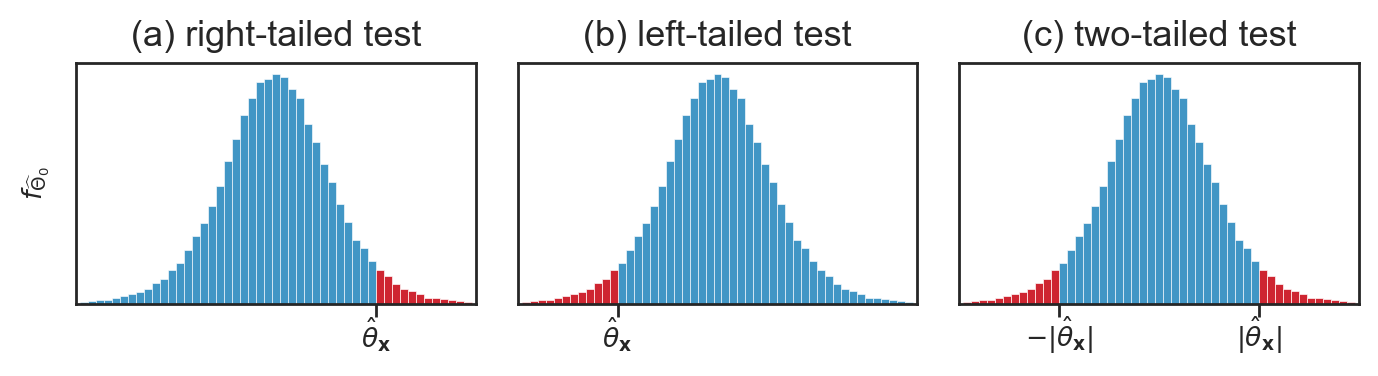

In [10]:
filename = os.path.join(DESTDIR, "panel_hist_p-values_left_twotailed_right_tests.pdf")
    
from scipy.stats import t as tdist
rvT = tdist(9)

xs = np.linspace(-4, 4, 1000)
ys = rvT.pdf(xs)

N = 100000
np.random.seed(42)
ts = rvT.rvs(N)

bins = nicebins(xs, 2, nbins=50)

with plt.rc_context({"figure.figsize":(7,2)}), sns.axes_style("ticks"):
    fig, (ax3, ax1, ax2) = plt.subplots(1, 3, sharey=True)
    ax3.set_ylabel("$f_{\widehat{\Theta}_0}$")

    # RIGHT
    title = '(a) right-tailed test'
    ax3.set_title(title, fontsize=13)
    sns.histplot(ts, ax=ax3, bins=bins)
    ax3.set_xlim(-4, 4)
    ax3.set_xticks([2])
    ax3.set_xticklabels([])
    ax3.set_yticks([])
    # highlight the right tail
    tailvalues3 = [t for t in ts if t >= 2]
    sns.histplot(tailvalues3, bins=bins, ax=ax3, color="red")
    ax3.text(2, -300, "$\hat{\\theta}_{\mathbf{x}}$", verticalalignment="top", horizontalalignment="center")
    
    # LEFT
    title = '(b) left-tailed test'
    ax1.set_title(title, fontsize=13)
    sns.histplot(ts, ax=ax1, bins=bins)
    
    ax1.set_xlim(-4, 4)
    ax1.set_xticks([-2])
    ax1.set_xticklabels([])
    ax1.set_yticks([])
    ax1.set_ylabel("")
    # highlight the left tail
    tailvalues1 = tailvalues(ts, -2, alt="less")
    sns.histplot(tailvalues1, bins=bins, ax=ax1, color="red")
    ax1.text(-2, -300, r"$\hat{\theta}_{\mathbf{x}}$", va="top", ha="center")

    # TWO-TAILED
    title = '(c) two-tailed test'
    ax2.set_title(title, fontsize=13)
    sns.histplot(ts, ax=ax2, bins=bins)
    ax2.set_xlim(-4, 4)
    ax2.set_xticks([-2,2])
    ax2.set_xticklabels([])
    ax2.set_yticks([])
    # highlight the left and right tails
    tailvalues2 = [t for t in ts if t <= -2 or t >= 2]
    sns.histplot(tailvalues2, bins=bins, ax=ax2, color="red")
    ax2.text(-2, -300, r"$-|\hat{\theta}_{\mathbf{x}}|$", verticalalignment="top", horizontalalignment="center")
    ax2.text(2, -300, r"$|\hat{\theta}_{\mathbf{x}}|$", verticalalignment="top", horizontalalignment="center")


savefigure(fig, filename)

Saved figure to figures/stats/intro_to_NHST/hist_p-value_right_tail_test.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_right_tail_test.png


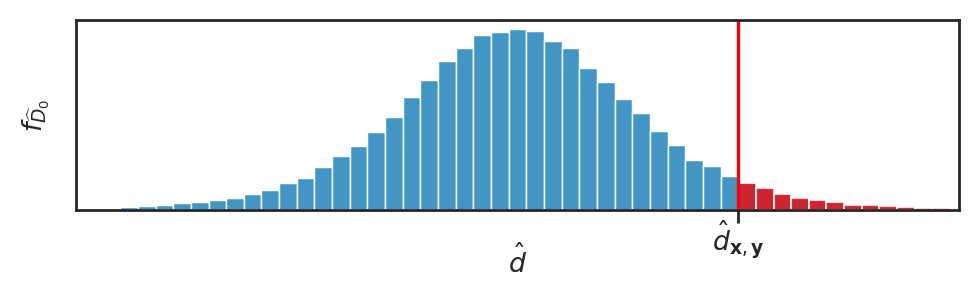

In [11]:
filename = os.path.join(DESTDIR, "hist_p-value_right_tail_test.pdf")

from scipy.stats import t as tdist
rvT = tdist(9)

xs = np.linspace(-4, 4, 1000)
ys = rvT.pdf(xs)

N = 100000
np.random.seed(42)
ts = rvT.rvs(N)

bins = nicebins(xs, 2, nbins=50)

with sns.axes_style("ticks"):
    fig, ax = plt.subplots()
    sns.histplot(ts, ax=ax, bins=bins)
    ax.set_xlabel("$\hat{d}$")
    ax.set_xlim(-4, 4)
    ax.set_xticks([2])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_ylabel("$f_{\widehat{D}_0}$")
    # highlight the right tail
    tailvaluesa = [t for t in ts if t >= 2]
    sns.histplot(tailvaluesa, bins=bins, ax=ax, color="red")
    ax.text(2, -300, "$\hat{d}_{\mathbf{x},\mathbf{y}}$", verticalalignment="top", horizontalalignment="center")
    plt.axvline(2, color="red")

savefigure(fig, filename)

In [12]:
#######################################################
def getdecision(pvalue, alpha=0.05):
    """
    Check if `pvalue` is less than or equal to `alpha`.
    """
    if pvalue < alpha:
        # The observed statistics is unlikely to have
        # occurred under the null hypothesis
        decision = "reject H0"
    else:
        # The observed statistics could have occurred
        # under the null hypothesis
        decision = "fail to reject H0"
    return decision

### Effect size estimation


#### Reminder on confidence intervals functions

In [13]:
from stats_helpers import ci_mean
from stats_helpers import ci_var
from stats_helpers import ci_dmeans

## Comparing one group to a theoretical model

Description of the problem: compare simple of obs. to an known population model

The calculation of the "tails" of the distribution 

### Kombucha bottling process

Reminder of kombucha bottling scenario where 
theory: $K \sim \mathcal{N}(\mu_K=1000, \sigma_K=10)$


Computational approach: simulation given mu_0 and sigma_0 are known

### Example 1: test mean of Batch 04 against the the null

$$
    H_0: \;\; \mu = \mu_0 = 1000,
    \qquad \qquad
    H_A: \;\; \mu \neq \mu_0.
$$

In words,
the null hypothesis describes a regular batch,
where the mean of the batch is equal to the mean of the model $\mu_0=\mu_K=1000$.

We'll show the hypothesis testing procedure for
two different batches from the `kombucha` dataset.

In [14]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch04 = kombucha[kombucha["batch"]==4]
ksample04 = batch04["volume"]

In [15]:
ksample04.count()

40

In [16]:
# observed mean
obsmean04 = mean(ksample04)
obsmean04

1003.8335

The mean volume calculated from the sample `ksample04` is $3.83$ ml higher than the expected mean $\mu_K = 1000$ ml.

Is this a big difference or not?

How likely is such deviation to occur by chance under the null hypothesis?

#### Obtain the sampling distribution under $H_0$ using simulation

To answer this question,
we need to generate the sampling distribution of the mean
for samples of size $n=40$ under the null hypothesis $H_0$.
We can do this using the `gen_sampling_dist` function,
by providing it the probability model `rvK` $=K = \mathcal{N}(\mu_K=1000,\sigma_K=10)$,
which describes the variability of the kombucha volumes when the factory is operating correctly.

In [95]:
from scipy.stats import norm

# theoretical model for the kombucha volumes
muK = 1000   # population mean (expected kombucha volume)
sigmaK = 10  # population variance
rvK = norm(muK, sigmaK)

We can now generate the sampling distribution using simulation...

In [95]:
from stats_helpers import gen_sampling_dist

np.random.seed(42)
kbars40 = gen_sampling_dist(rvK, estfunc=mean, n=40)

To calculate the $p$-value, we want
want to calculate how many values of sampling distribution `kbars40`
are equal or more extreme than the observed value $\overline{\mathbf{k}}_{04} = $ `obsmean04` = 1003.8335.

In [96]:
tails = tailvalues(kbars40, obsmean04)
pvalue04 = len(tails) / len(kbars40)
pvalue04

0.0147

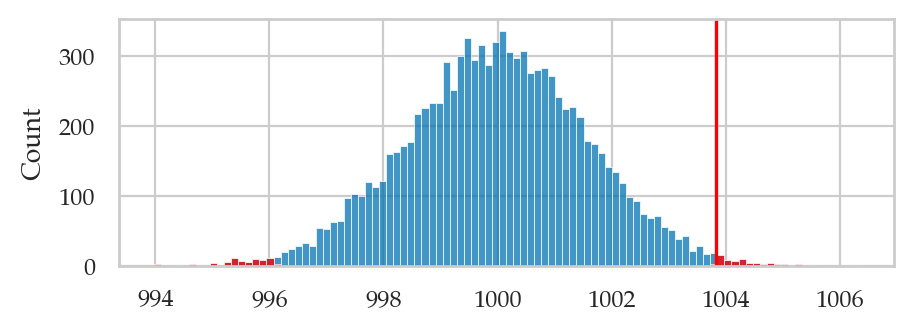

In [19]:
# plot the sampling distribution as a histogram
sns.histplot(kbars40, bins=100)

# plot red line for the observed mean
plt.axvline(obsmean04, color="red")

# plot the values that are equal or more extreme in red
_ = sns.histplot(tails, bins=100, color="red")

Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsmean04.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsmean04.png


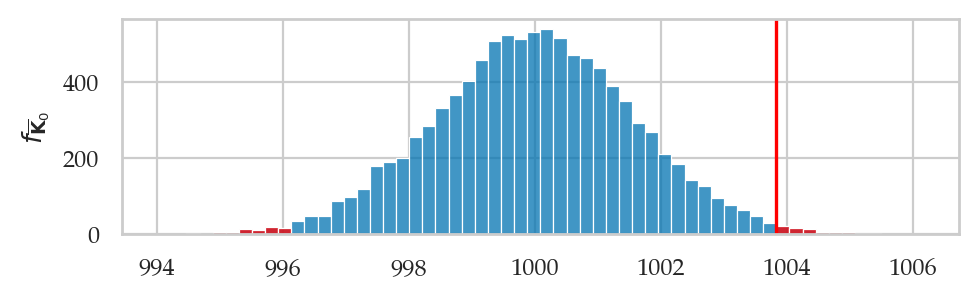

In [20]:
filename = os.path.join(DESTDIR, "hist_p-value_kombucha_obsmean04.pdf")

# plot the sampling distribution as a histogram
bins = nicebins(kbars40, obsmean04)
ax = sns.histplot(kbars40, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsmean04, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel("$f_{\overline{\mathbf{K}}_0}$")

savefigure(ax, filename)

We can now make the decision based on the $p$-value and a pre-determined threshold,
which is conventionally chosen $\alpha=0.05$ (1 in 20):

- If the observed value of the mean `obsmean04` = 1003.8335 is unlikely under
  $H_0$ ($p$-value less than 5% chance of occurring),
  then our decision will be to "reject the null hypothesis."
- Otherwise, if the observed value `obsmean04` is not that unusual ($p$-value greater than 5%),
  we conclude that we have "fail to reject the null hypothesis."

In [21]:
getdecision(pvalue04)

'reject H0'

Recall the math statement of the null hypothesis is $H_0: \mu = \mu_K = 1000$,
which describes a batch whose mean is equal to the mean of the model $\mu_K$.
The conclusion to reject $H_0$ means the batch is irregular.

#### Calculating the effect size

We were able to detect that batch differs from the expected distribution,
but how big is this deviation?
We can use the deviation from the expected mean as measure of the effect size $\Delta = \overline{\mathbf{k}} - \mu_K$ in this situation.

In [22]:
mean(ksample04) - muK

3.833499999999958

The point estimate $\Delta = \overline{\mathbf{k}} - \mu_K = 3.83$
tells us how much the mean of the sample differs from the expected population mean $\mu_K$,
but doesn't tell us the uncertainty in this estimate.

#### Confidence interval for the effect size

The bootstrap confidence interval for the effect size 
$\ci{\Delta,0.9}^*$ tells us a range of plausible values for the effect size.


In [100]:
from stats_helpers import gen_boot_dist

np.random.seed(48)
D_boot = gen_boot_dist(ksample04-muK, estfunc=mean)
[np.percentile(D_boot, 5),
 np.percentile(D_boot, 95)]

[1.7537499999999935, 5.802025000000007]

Recall the function `ci_mean` we defined previously that does this.

In [24]:
np.random.seed(48)
ci_mean(ksample04-muK, alpha=0.1, method="b")

[1.7537499999999935, 5.802025000000007]

The interval $\ci{\Delta,0.9}^* = [1.75, 5.80]$ tells us the true discrepancy
of Batch 04 from the expected mean can be anywhere from 1.75 to 5.8.

### Example 2: test mean of Batch 01 against the the null

Let's repeat the procedure on the sample 

In [25]:
batch01 = kombucha[kombucha["batch"]==1]
ksample01 = batch01["volume"]
ksample01.count()

40

In [26]:
obsmean01 = mean(ksample01)
obsmean01

999.10375

In [98]:
np.random.seed(42)
kbars40 = gen_sampling_dist(rvK, estfunc=mean, n=40)
tails = tailvalues(kbars40, obsmean01)
pvalue01 = len(tails) / len(kbars40)
pvalue01

0.5708

Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsmean01.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsmean01.png


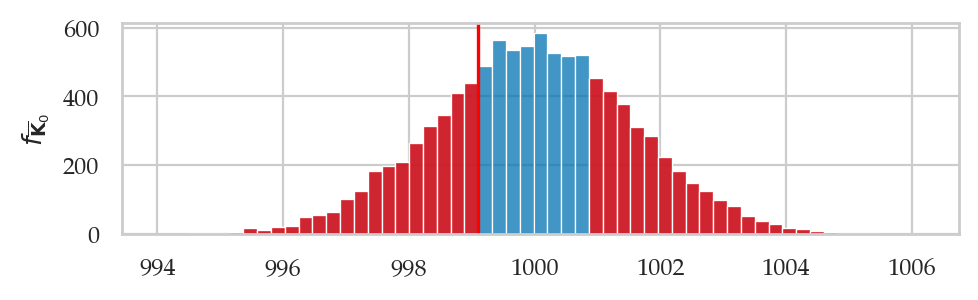

In [28]:
filename = os.path.join(DESTDIR, "hist_p-value_kombucha_obsmean01.pdf")

# plot the sampling distribution as a histogram
bins = nicebins(kbars40, obsmean01)
ax = sns.histplot(kbars40, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsmean01, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel("$f_{\overline{\mathbf{K}}_0}$")

savefigure(ax, filename)

In [29]:
getdecision(pvalue01)

'fail to reject H0'

The observed mean from batch 01 is not unlikely under $H_0$,
so batch 01 is OK.

Using the terminology of hypothesis testing,
we say the outcome of the hypothesis test is "fail to reject $H_0: \mu = \mu_K$."
We have not seen any evidence that suggests that the mean of the population from
which sample `ksample01` was taken differs from the mean of the expected model $K$.

Ship it!

### Reusable test function for the mean

In [30]:
#######################################################

def simulation_test_mean(sample, mu0, sigma0, N=10000):
    """
    Compute the p-value of the observed mean of `sample`
    under H0 of a normal distribution `norm(mu0,sigma0)`.
    """
    # Compute the observed value of the mean
    obsmean = mean(sample)
    n = len(sample)

    # Get sampling distribution of the mean under H0
    rvXH0 = norm(mu0, sigma0)
    xbars = gen_sampling_dist(rvXH0, estfunc=mean, n=n)

    # Compute the p-value
    tails = tailvalues(xbars, obsmean)
    pvalue = len(tails) / len(xbars)
    return pvalue

In [31]:
## TEST 1 (Do we get the same answer for Batch 04?)
simulation_test_mean(ksample04, mu0=muK, sigma0=sigmaK)[1]

0.0149

In [32]:
## TEST 2 (Do we get the same answer for Batch 01?)
simulation_test_mean(ksample01, mu0=muK, sigma0=sigmaK)[1]

0.5732

### Example 3: test variance of Batch 02 against the null

$$
    H_0: \;\; \sigma \leq \sigma_0 = 10,
    \qquad \qquad
    H_A: \;\; \sigma > \sigma_0.
$$

In [33]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch02 = kombucha[kombucha["batch"]==2]
ksample02 = batch02["volume"]
ksample02.count()

20

In [34]:
obsvar02 = var(ksample02)
obsvar02

124.31760105263136

In [78]:
np.random.seed(42)
kvars20 = gen_sampling_dist(rvK, estfunc=var, n=20)
tails = tailvalues(kvars20, obsvar02, alt="greater")
pvalue = len(tails) / len(kvars20)
pvalue

0.2132

Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsvar02.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsvar02.png


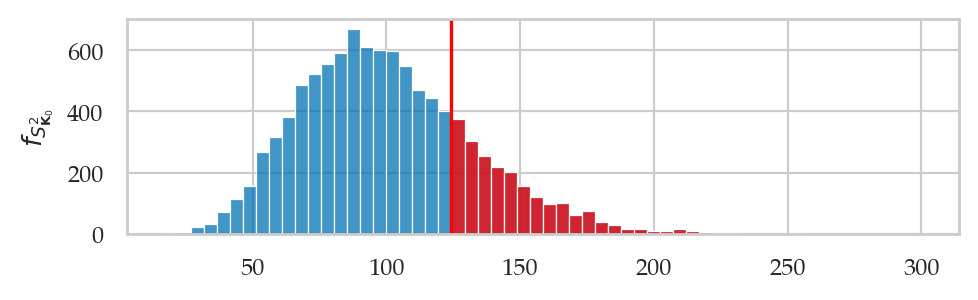

In [79]:
filename = os.path.join(DESTDIR, "hist_p-value_kombucha_obsvar02.pdf")

# plot the sampling distribution as a histogram
bins = nicebins(kvars, obsvar02)
ax = sns.histplot(kvars, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsvar02, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel("$f_{S^2_{\mathbf{K}_0}}$")

savefigure(ax, filename)

### Example 4: test variance of Batch 08 against the null

In [37]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch08 = kombucha[kombucha["batch"]==8]
ksample08 = batch08["volume"]
ksample08.count()

40

In [38]:
obsvar08 = var(ksample08)
obsvar08

169.9979220512824

In [86]:
np.random.seed(43)
kvars40 = gen_sampling_dist(rvK, estfunc=var, n=40)
tails = tailvalues(kvars40, obsvar08, alt="greater")
pvalue = len(tails) / len(kvars40)
pvalue

0.0041

Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsvar08.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_kombucha_obsvar08.png


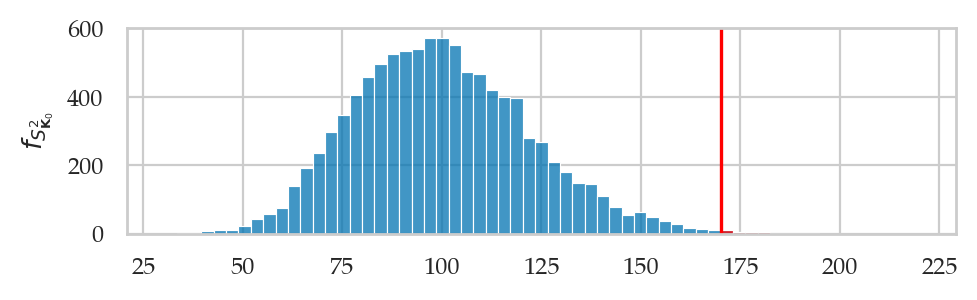

In [88]:
filename = os.path.join(DESTDIR, "hist_p-value_kombucha_obsvar08.pdf")

# plot the sampling distribution as a histogram
bins = nicebins(kvars40, obsvar08)
ax = sns.histplot(kvars40, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsvar08, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel("$f_{S^2_{\mathbf{K}_0}}$")

savefigure(ax, filename)

#### Calculating the effect size

We found the variance in the volumes in this batch is higher than the expected variance.
Now let's estimate the effect size $\Delta = s^2_{\mathbf{k}_{08}} - \sigma_K^2$.


In [89]:
var(ksample08) - sigmaK**2

69.99792205128239

#### Confidence interval for the effect size

The bootstrap confidence interval for the effect size 
$\ci{\Delta,0.9}^*$ tells us a range of plausible values for the effect size.


In [104]:
from stats_helpers import gen_boot_dist

np.random.seed(48)
kvars40_boot = gen_boot_dist(ksample08, estfunc=var)
D_boot = np.subtract(kvars40_boot, sigmaK**2)
[np.percentile(D_boot, 5),
 np.percentile(D_boot, 95)]

[17.37369362820539, 117.98659930448767]

The interval $\ci{\Delta,0.9}^* = [17, 118]$ tells us the difference
in the variance of Batch 08 from the expected variance is somewhere between 17 and 118.

### Generic simulation test function

In [91]:
#######################################################

def simulation_test_var(sample, mu0, sigma0, alt="greater"):
    """
    Compute the p-value of the observed variance of `sample`
    under H0 of a normal distribution `norm(mu0,sigma0)`.
    """
    # 1. Compute the sample variance
    obsvar = var(sample)
    n = len(sample)

    # 2. Get sampling distribution of variance under H0
    rvXH0 = norm(mu0, sigma0)
    xvars = gen_sampling_dist(rvXH0, estfunc=var, n=n)

    # 3. Compute the p-value
    tails = tailvalues(xvars, obsvar, alt=alt)
    pvalue = len(tails) / len(xvars)
    return pvalue

In [107]:
# reproduce the results from Examle 3
np.random.seed(42)
simulation_test_var(ksample02, muK, sigmaK, alt="greater")

0.2132

In [106]:
# reproduce the results from Examle 4
np.random.seed(43)
simulation_test_var(ksample08, muK, sigmaK, alt="greater")

0.0041

## Comparing two groups

Description of the problem: compare two group based on sample means computed from each group.

### Computational approach: permutation test

The permutation test (also known as randomization test) for comparing two groups

Computational approach: permutation test (a way to simulate dist. under null hypothesis)
Obtaining samples from a hypothetical distribution of "no difference between groups" is equivalent to forgetting the group-membership labels in the sample.

EDITME


- The permutation test allow us to generate the sampling distribution under $H_0$
  by reusing the sample $\mathbf{x}$ that we have,
  treating it as if it were a population.
- Relevant probability distributions:
  - Real sampling distribution: obtained from repeated samples from a hypothetical population under $H_0$.
  - Approximate sampling distribution: obtained by **resampling data from the single sample we have**.
- Recall Goal 1: make sure that the observed difference is unlikely to have occurred by chance under $H_0$
  (the difference between group means $d=130$ cannot be explained by the natural variability of the distributions)
  - We want to obtain an approximation of the sampling distribution under $H_0$
  - The $H_0$ probability model describes a hypothetical scenario with **no difference between groups**,
    which means data from **Group S** and **Group NS** comes the same distribution.
  - To generate a new random sample $\mathbf{x}^p$ from the $H_0$ model,
    we can reuse the sample we have obtained $\mathbf{x}$,
    but randomly mix-up the group labels.
    Since under the $H_0$ model, the **S** and **NS** populations are identical,
    mixing up the labels should have no effect.
  - The math term for "mixing up" is **permutation**, meaning 
    each value in the input is randomly reassigned to a new random place in the output.

In [46]:
#######################################################
def resample_under_H0(sample1, sample2):
    """
    Generate new samples from a random permutation of
    the values in the samples `sample1` and `sample2`.
    """
    values = np.concatenate((sample1, sample2))
    shuffled_values = np.random.permutation(values)
    resample1 = shuffled_values[0:len(sample1)]
    resample2 = shuffled_values[len(sample1):]
    return resample1, resample2

In [47]:
# example
resample_under_H0([1,1,1], [2,2,2,2])

(array([1, 1, 2]), array([2, 2, 2, 1]))

The function `resample_under_H0` gives us a way to generate samples from the null hypothesis.
We can then compute the value of the `dmeans` statistic for these samples. We used the assumption of "no difference" under the null hypothesis, and translated this to the "forget the labels" interpretation.

In [48]:
def permutation_test_dmeans(sample1, sample2, P=10000):
    # 1. Compute the observed difference between means
    obsdhat = dmeans(sample1, sample2)

    # 2. Get sampling dist. of `dmeans` under H0
    pdhats = []
    for i in range(0, P):
        rs1, rs2 = resample_under_H0(sample1, sample2)
        pdhat = dmeans(rs1, rs2)
        pdhats.append(pdhat)

    # 3. Compute the p-value
    tails = tailvalues(pdhats, obsdhat)
    pvalue = len(tails) / len(pdhats)
    return pvalue

# usage:
#   permutation_test_dmeans(xsample, ysample)

### Example 5: electricity prices

$$ 
   H_A: \qquad X_W = \mathcal{N}(\color{blue}{\mu_W}, \sigma_W)
   \quad \textrm{and} \quad
   X_{E} = \mathcal{N}(\color{orange}{\mu_{E}}, \sigma_{E})
$$

$$ 
   H_0: \qquad X_W = \mathcal{N}(\color{red}{\mu_0}, \sigma_W)
   \quad \textrm{and} \quad
   X_{E} = \mathcal{N}(\color{red}{\mu_0}, \sigma_{E})
$$







In [49]:
eprices = pd.read_csv("../datasets/eprices.csv")
# eprices

In [50]:
eprices.groupby("end")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
end,,,,,,,,
East,9.0,6.155556,0.877655,4.8,5.5,6.3,6.5,7.7
West,9.0,9.155556,1.562139,6.8,8.3,8.6,10.0,11.8


In [51]:
pricesW = eprices[eprices["end"]=="West"]["price"]
pricesE = eprices[eprices["end"]=="East"]["price"]

# observed difference between means
dhat = dmeans(pricesW, pricesE)
dhat

3.0

Our goal is to determine how *likely* or *unlikely* this observed value $\hat{d}=3$ is under the null hypothesis $H_0$. This means we need to obtain the sampling distribution of $\hat{D}$ under $H_0$, which we can do using the permutation test.

Let's look at some of the differences we can expect to observe under $H_0$.

In [52]:
#######################################################
# generate new samples by shuffling the labels
pricesWb, pricesEb = resample_under_H0(pricesW, pricesE)

# compute the difference in means for the bootstrap samples
dmeans(pricesWb, pricesEb)

-0.6888888888888891

EDITME #### Running a permutation test

We can repeat the resampling procedure `10000` times to get the sampling distribution of $D$ under $H_0$,
as illustrated in the code procedure below.

EDITME 

- Once we have the sampling distribution of `D` under $H_0$,
  we can see where the observed value $d=130$
  falls within this distribution.
- p-value: the probability of observing value $d=130$ or more extreme under the null hypothesis

In [53]:
#######################################################
dhats, pval = permutation_test_dmeans(pricesW, pricesE)
pval

0.0004

Saved figure to figures/stats/intro_to_NHST/hist_p-value_dmeans_eprices.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_dmeans_eprices.png


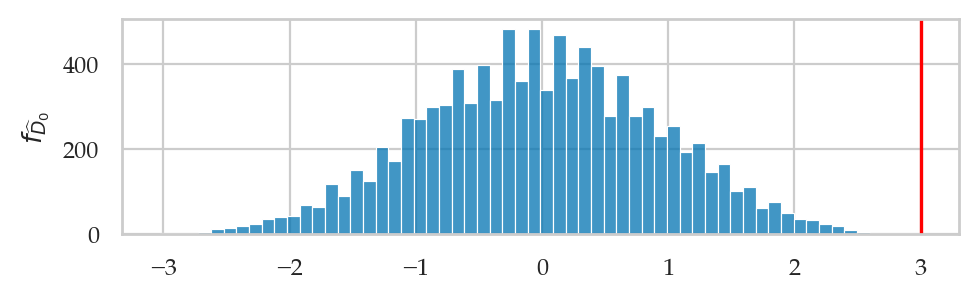

In [54]:
filename = os.path.join(DESTDIR, "hist_p-value_dmeans_eprices.pdf")

# plot the sampling distribution in blue
bins = nicebins(dhats, dhat)
ax = sns.histplot(dhats, bins=bins)

# plot red line for the observed statistic
plt.axvline(dhat, color="red")

# plot the values that are equal or more extreme in red
tails = tailvalues(dhats, dhat)
sns.histplot(tails, ax=ax, bins=bins, color="red")
ax.set_ylabel("$f_{\widehat{D}_0}$")

savefigure(ax, filename)

#### Permutations test using SciPy (optional)

The above code was given only for educational purposes.
In practice, you can use the SciPy implementation of permutation test,
by calling `ttest_ind(..., permutations=10000)` to perform a permutation test, then obtain the $p$-value.

In [55]:
from scipy.stats import ttest_ind

ttest_ind(pricesW, pricesE, permutations=10000).pvalue

0.00019998000199980003

Note the $p$-value we obtained form the two methods may be different:
this happens whenever we use the permutations test,
because we use randomness as part of the calculation.

### Example 6: lecture and debate curriculums

In [56]:
students = pd.read_csv("../datasets/students.csv")
# students

In [57]:
students.groupby("curriculum")["score"].describe()

,count,mean,std,min,25%,50%,75%,max
curriculum,,,,,,,,
debate,8.0,76.462500,10.519633,62.9,69.55,75.55,80.925,96.2
lecture,7.0,68.142857,7.758406,57.0,63.30,70.30,73.850,75.4


In [58]:
scoresD = students[students["curriculum"]=="debate"]["score"]
scoresL = students[students["curriculum"]=="lecture"]["score"]

# observed difference between means
dhat = dmeans(scoresD, scoresL)
dhat

8.319642857142853

Our goal is to determine how *likely* or *unlikely* this observed value $\hat{d}=3$ is under the null hypothesis $H_0$. This means we need to obtain the sampling distribution of $\hat{D}$ under $H_0$, which we can do using the permutation test.

Let's look at some of the differences we can expect to observe under $H_0$.

In [59]:
#######################################################
# generate new samples by shuffling the labels
scoresDb, scoresLb = resample_under_H0(scoresD,scoresL)

# compute the difference in means for the bootstrap samples
dmeans(scoresDb, scoresLb)

0.15000000000000568

In [60]:
#######################################################
dhats, pval = permutation_test_dmeans(scoresD, scoresL)
pval

0.1108

Saved figure to figures/stats/intro_to_NHST/hist_p-value_dmeans_students.pdf
Saved figure to figures/stats/intro_to_NHST/hist_p-value_dmeans_students.png


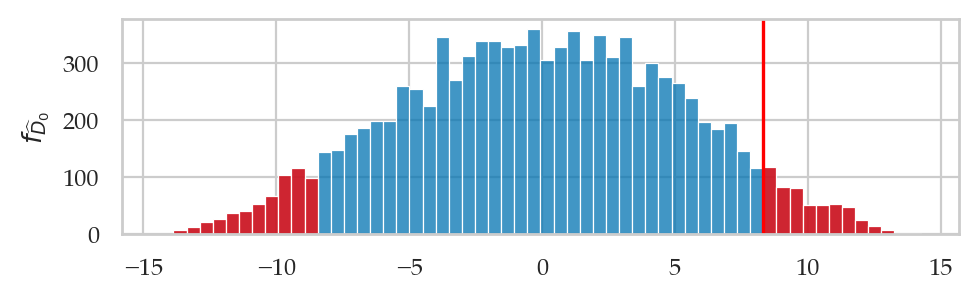

In [61]:
filename = os.path.join(DESTDIR, "hist_p-value_dmeans_students.pdf")

# plot the sampling distribution in blue
bins = nicebins(dhats, dhat)
ax = sns.histplot(dhats, bins=bins)

# plot red line for the observed statistic
plt.axvline(dhat, color="red")

# plot the values that are equal or more extreme in red
tails = tailvalues(dhats, dhat)
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel("$f_{\widehat{D}_0}$")

savefigure(ax, filename)

### Discussion

  - The procedure we used is called a **permutations test** for comparison of group means.
  - The permutation test takes it's name from the action of mixing up the group-membership labels
    and computing a statistic which is a way to generate samples from the null hypothesis
    in situations where we're comparing two groups.
  - Permutation tests are very versatile since we can use them for any estimator $g(\mathbf{x})$.
    For example, we could have used difference in medians by specifying the `median` as the input `estfunc`.


## Explanations

### Statistical modelling and assumptions

### Two different probability models

### One-sided and two-sided tests

### Court trial analogy

## Discussion

### Standardized effect size

It is sometimes useful to report the effect size using a "standardized" measure for effect sizes.

Cohen's $d$ is one such measure, and it is defined as the difference between two means divided by the pooled standard deviation.

In [62]:
def cohend(sample, mu):
    """
    Compute Cohen's d for one group compared to the theoretical mean `mu`.
    """
    mean = np.mean(sample)
    std = np.std(sample, ddof=1)
    cohend = (mean - mu) / std
    return cohend

def cohend2(sample1, sample2):
    """
    Compute Cohen's d measure of effect size for two independent samples.
    """
    n1, n2 = len(sample1), len(sample2)
    mean1, mean2 = np.mean(sample1), np.mean(sample2)
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)
    # calculate the pooled variance and standard deviaiton
    var_pooled = ((n1-1)*var1 + (n2-1)*var2) / (n1 + n2 - 2)
    std_pooled = np.sqrt(var_pooled)
    cohend = (mean1 - mean2) / std_pooled
    return cohend

We can interpret the value of Cohen's d obtained using the [reference table](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d) of values:

| Cohen's d   | Effect size |
| ----------- | ----------- |
| 0.01        | very small  |
| 0.20        | small       |
| 0.50        | medium      |
| 0.80        | large       |


In [63]:
# Effect size for kombucha batch 04
cohend(ksample04, mu=1000)

0.48820873453216374

In [64]:
# Effect size difference in electricity prices
cohend2(pricesW, pricesE)

2.367806224329099

In [65]:
# Effect size student scores
cohend2(scoresD, scoresL)

0.8900742000749484

## Exercises

In [66]:
# TODO

## Links

* [The Introductory Statistics Course: A Ptolemaic Curriculum](https://minireference.com/blog/wp-content/uploads/2021/03/TheIntroductoryStatisticsCourse__Cobb.pdf) by George W. Cobb
* [Permutation Methods: A Basis for Exact Inference](https://projecteuclid.org/journals/statistical-science/volume-19/issue-4/Permutation-Methods-A-Basis-for-Exact-Inference/10.1214/088342304000000396.full) by Michael D. Ernst
* [What Teachers Should Know About the Bootstrap: Resampling in the Undergraduate Statistics Curriculum](https://www.tandfonline.com/doi/full/10.1080/00031305.2015.1089789) by Tim C. Hesterberg  
* \[BOOK\] [Think Stats 2e](https://greenteapress.com/wp/think-stats-2e/) by Allen B. Downey  
* \[VIDEO\] [There's Only One Test](https://www.youtube.com/watch?v=S41zQEshs5k) by Allen B. Downey
* \[TALK\] [Statistics for Hackers](https://www.youtube.com/watch?v=Iq9DzN6mvYA) by Jake Vanderplas


New links:

* Nice animation https://commons.wikimedia.org/wiki/File:Permutation_test_example_animation.gif  
  via https://en.wikipedia.org/wiki/Permutation_test

# Imported stuff from overview

### Summary of Question 1

We saw two ways to answer Question 1 (is there really a difference between group means) and obtain the $p$-value.
We interpreted the small $p$-values as evidence that the observed difference, $d=130$, is unlikely to be due to chance under $H_0$, so we rejected the null hypothesis.
Note this whole procedure is just a sanity check—we haven't touched the alternative hypothesis at all yet,
and for all we know the stats training could have the effect of decreasing ELV!


 
____

It's time to study Question 2, which is to estimate the *magnitude* of the change in ELV obtained from completing the stats training. We call this the *effect size* in statistics.

## Estimating the effect size

- Question 2 of Amy's statistical investigation is to estimate the difference in ELV gained by stats training.
- NEW CONCEPT: **effect size** is a measure of difference between intervention and control groups.
- We assume the data of **Group S** and **Group NS** come from different populations with means $\mu_S$ and $\mu_{NS}$.
- We're interested in estimating the difference between population means, denoted $\Delta = \mu_S - \mu_{NS}$.
- By analyzing the sample, we have obtained an estimate $d=130$ for the unknown $\Delta$,
  but we know our data contains lots of variability, so we know our estimate might be off.
- We want an answer to Question 2 (What is the estimated difference between group means?)
  that takes into account the variability of the data.
- NEW CONCEPT: **confidence interval** is a way to describe a range of values for an estimate
  that takes into account the variability of the data.
- We want to provide an answer to Question 2 in the form of a confidence interval that tells
  us a range of values where we believe the true value of $\Delta$ falls.
- Similar to how we showed two approaches for hypothesis testing,
  we'll work on effect size estimation using two approaches: bootstrap estimation and analytical approximation methods.


### Approach 1: Confidence intervals using bootstrap estimation

- We want to estimate the distribution of ELV values for the two groups,
  and compute the difference between the means of these distributions.
- Distributions:
  - Real sampling distributions: obtained by repeated sampling from the populations
  - Bootstrap sampling distributions: resampling data from the samples we have (with replacement)
- Intuition: treat the samples as if they were the population
- We'll compute $B=5000$ bootstrap samples from the two groups and compute the differences.
  We'll then look at the distribution of the bootstrap sample differences to obtain
  the confidence interval for the difference between population means $CI_{\Delta}$.

In [67]:
def gen_boot_dist(sample, estfunc, B=10000):
    """
    Generate estimates from the sampling distribiton of the estimator `estfunc`
    based on `B` bootstrap samples (sampling with replacement) from `sample`.
    """
    n = len(sample)
    bestimates = []
    for i in range(0, B):
        bsample = np.random.choice(sample, n, replace=True)
        bestimate = estfunc(bsample)
        bestimates.append(bestimate)
    return bestimates

<AxesSubplot: ylabel='Count'>

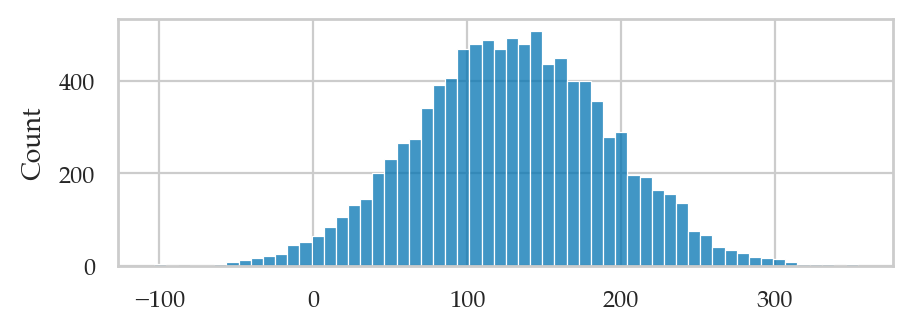

In [68]:
from statistics import mean

# load data for two groups
data = pd.read_csv('../stats_overview/data/employee_lifetime_values.csv')
xS = data[data["group"]=="S"]['ELV']
xNS = data[data["group"]=="NS"]['ELV']

# compute bootstrap estimates for mean in each group
meanS_bstats = gen_boot_dist(xS, estfunc=mean)
meanNS_bstats = gen_boot_dist(xNS, estfunc=mean)

# compute the difference between means from bootstrap samples
dmeans_bstats = []
for bmeanS, bmeanNS in zip(meanS_bstats, meanNS_bstats):
    d = bmeanS - bmeanNS 
    dmeans_bstats.append(d)

sns.histplot(dmeans_bstats)

In [69]:
# 90% confidence interval for the difference in means
CI_boot = [np.percentile(dmeans_bstats, 5),
           np.percentile(dmeans_bstats, 95)]
CI_boot

[26.164554301075146, 233.19802473118273]

The 90% confidence interval `CI_boot` describes an interval of numbers
that should contain the difference between group means $\Delta$ at least 90\% of the time:

$$
    \textrm{Pr}_{R}\big(\{ \Delta \in \textrm{CI}_{\Delta} \}\big) \geq 0.9.
$$

This is a little weird:
in any given experiment,
the unknown difference between groups $\Delta$ either *is* or *isn't* in the interval $\textrm{CI}_{\Delta}$,
so what is 90\% probability referring to?
The randomness $R$ describes repeated experiments using the same calculation procedure for calculating the confidence interval.
So it is not a guarantee on any particular estimate,
but reliability of the procedure in the long term.
This is the *frequentist statistics* paradigm,
in which "quality guarantees" are given about the procedure used to obtain the estimates,
and not about particular outcomes of the procedure.

#### SciPy bootstrap method

In [70]:
from scipy.stats import bootstrap

def dmeans2(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

res = bootstrap((xS, xNS), statistic=dmeans2, vectorized=False,
                confidence_level=0.9, n_resamples=5000, method='percentile')

CI_boot2 = [res.confidence_interval.low, res.confidence_interval.high]
CI_boot2

[27.537827956989393, 233.4688575268817]

## Conclusion of Amy's statistical analysis

Recall the two research questions that Amy set out to answer in the beginning of this video series:

- Question 1: Is there a difference between the means in the two groups?
- Question 2: How much does statistics training improve the ELV of employees?

The statistical analysis we did allows us to answer these two questions as follows:

- Answer 1: There is a statistically significant difference between Group S and Group NS, $p = 0.048$.
- Answer 2: The estimated improvement in ELV is 130 points, which is corresponds to Cohen's d value of $0.52$ (medium effect size). A 90% confidence interval for the true effect size is $[28.4, 237.6]$.

Note: we reported the numerical results obtained from resampling methods (Approach 1), but conclusions would be qualitatively the same if we reported results obtained from analytical approximations (Approach 2).

### Using statistics for convincing others

You may be wondering if all this probabilistic modelling and complicated statistical analysis was worth it to reach a conclusion that seems obvious in retrospect. Was all this work worth it? The purpose of all this work is to obtains something close to an objective conclusion. Without statistics it is very easy to fool ourselves and interpret patterns in data the way we want to, or alternatively, not see patterns that are present. By following the standard statistical procedures, we're less likely to fool ourselves, and more likely to be able to convince others.

It can be very useful to imagine Amy explaining the results to a skeptical colleague. Suppose the colleague is very much against the idea of statistical training, and sees it as a distraction, saying things like "We hire employees to do a job, not to play with Python." and "I don't know any statistics and I'm doing my job just fine!" You get the picture.

Imagine Amy presenting her findings about how 100 hours of statistical training improves employee lifetime value (ELV) results after one year, and suggesting the statistical training be implemented for all new hires from now on. The skeptical colleague immediately rejects the idea and questions Amy's recommendation using emotional appeals about necessity, time wasting, and how statistics is a specialty topic that is not required for all employees. Instead of arguing based on opinions and emotions with her colleague, Amy explains her recommendation is based on a statistical experiment she conducted, and shows the results:

- When the colleague asks if the observed difference could be due to chance, Amy says that this is unlikely, and quotes the $p$-value of 0.048 (less than 0.05), and interprets the result as saying the probability of the observed difference between **Group S** and **Group NS** being due to chance is less than 5%.

- The skeptical colleague is forced to concede that statistical training does improve ELV, but then asks about the effect size of the improvement: "How much more ELV can we expect if we provide statistics training?" Amy is ready to answer quoting the observed difference of $130$ ELV points, and further specifies the 90% confidence interval of $[28.4, 237.6]$ for the improvement, meaning in the worst case there is 28 ELV points improvement.

The skeptic is forced to back down from their objections, and the "stats training for all" program is adopted in the company. Not only was Amy able to win the argument using statistics, but she was also able to set appropriate expectations for the results. In other words, she hasn't promised a guaranteed +130 ELV improvement, but a realistic range of values that can be expected.

# CUT MATERIAL